In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Activation, Input
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_data(image_folder, mask_folder):
    images = []
    masks = []
    for filename in os.listdir(image_folder):
        img = cv2.imread(os.path.join(image_folder, filename))
        img = cv2.resize(img, (224, 224))  # Resize for ResNet101 input size
        images.append(img)
        mask = cv2.imread(os.path.join(mask_folder, filename), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (28, 28))  # Resize to match model output size
        mask = np.expand_dims((mask > 127).astype(np.uint8), axis=-1)  # Convert to binary mask and add channel dimension
        masks.append(mask)
    return np.array(images), np.array(masks)

In [ ]:
train_images, train_masks = load_data("/content/drive/MyDrive/Water Bodies Dataset/training_images", "/content/drive/MyDrive/Water Bodies Dataset/training_masks")

In [ ]:
test_images, test_masks = load_data("/content/drive/MyDrive/Water Bodies Dataset/test_images", "/content/drive/MyDrive/Water Bodies Dataset/test_masks")

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0


In [ ]:
def create_model(input_shape):
    resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in resnet101.layers:
        layer.trainable = False

    # Add convolutional layers for segmentation
    x = resnet101.output
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((4, 4))(x)  # Upsample to match the desired output size
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)

    return Model(inputs=resnet101.input, outputs=x)


In [ ]:
model = create_model(input_shape=(224, 224, 3))

In [ ]:
model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])


In [ ]:
model.fit(train_images, train_masks, epochs=10, batch_size=8, validation_split=0.2)


Epoch 1/10
199/199 [==============================] - 774s 4s/step - loss: 0.6256 - accuracy: 0.6931 - val_loss: 0.5705 - val_accuracy: 0.7107
Epoch 2/10
199/199 [==============================] - 763s 4s/step - loss: 0.5771 - accuracy: 0.7071 - val_loss: 0.5676 - val_accuracy: 0.7156
Epoch 3/10
199/199 [==============================] - 759s 4s/step - loss: 0.5741 - accuracy: 0.7115 - val_loss: 0.5642 - val_accuracy: 0.7116
Epoch 4/10
199/199 [==============================] - 759s 4s/step - loss: 0.5662 - accuracy: 0.7149 - val_loss: 0.5609 - val_accuracy: 0.7171
Epoch 5/10
199/199 [==============================] - 759s 4s/step - loss: 0.5622 - accuracy: 0.7153 - val_loss: 0.5586 - val_accuracy: 0.7235
Epoch 6/10
199/199 [==============================] - 752s 4s/step - loss: 0.5560 - accuracy: 0.7222 - val_loss: 0.5618 - val_accuracy: 0.7067
Epoch 7/10
199/199 [==============================] - 757s 4s/step - loss: 0.5558 - accuracy: 0.7220 - val_loss: 0.5516 - val_accuracy: 0.7194

In [ ]:
loss, accuracy = model.evaluate(test_images, test_masks)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

27/27 [==============================] - 312s 11s/step - loss: 0.5462 - accuracy: 0.7342
Test Loss: 0.5462238192558289
Test Accuracy: 0.7342168688774109


In [ ]:
predicted_masks = model.predict(test_images)


27/27 [==============================] - 314s 12s/step


In [ ]:
water_probability = np.mean(predicted_masks)
water_percentage = np.sum(predicted_masks) / np.sum(test_masks)

In [ ]:
print("Water Probability:", water_probability)
print("Water Percentage:", water_percentage*10)

Water Probability: 0.33757594
Water Percentage: 10.565374998829993


Image 1 - Water Probability: 0.29121536016464233


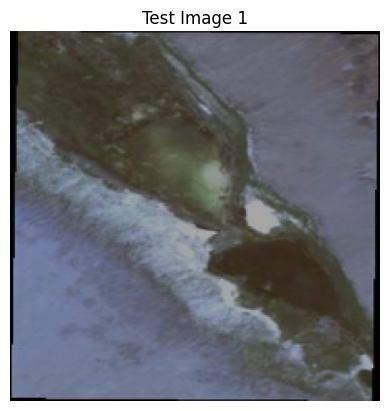

Image 2 - Water Probability: 0.40245944261550903


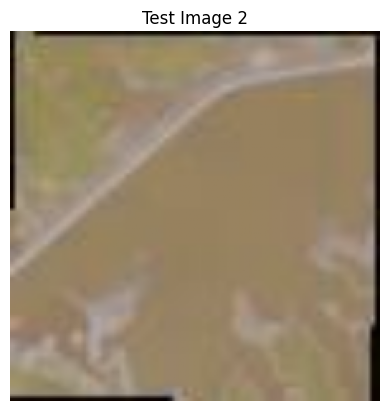

Image 3 - Water Probability: 0.43774744868278503


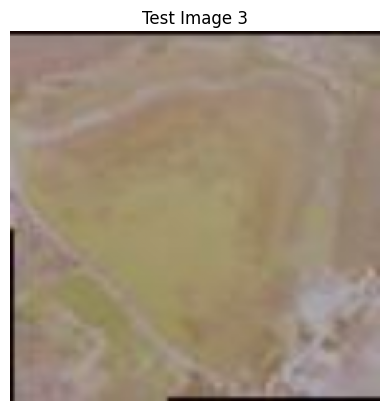

Image 4 - Water Probability: 0.38361024856567383


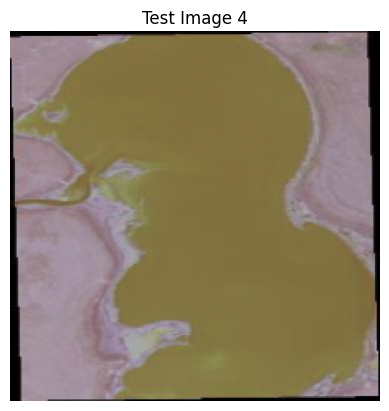

Image 5 - Water Probability: 0.4004937708377838


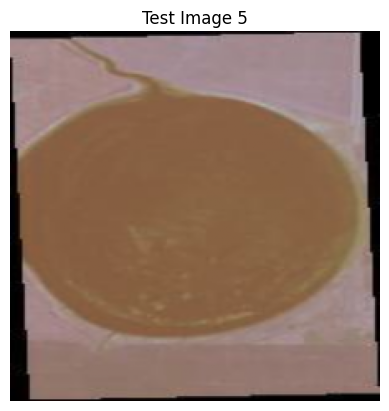

Image 6 - Water Probability: 0.25284069776535034


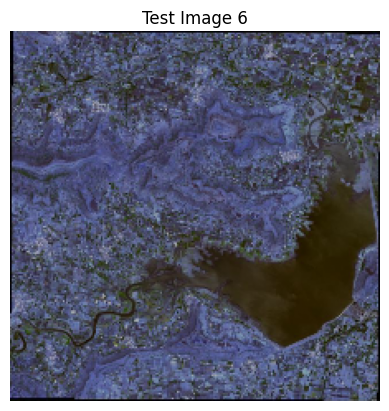

Image 7 - Water Probability: 0.30589500069618225


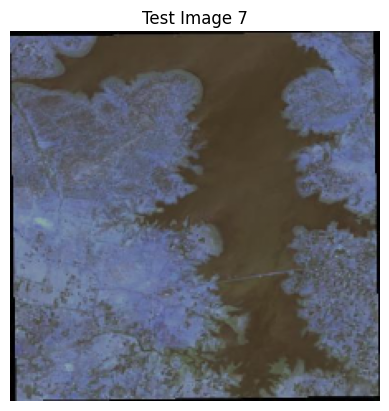

Image 8 - Water Probability: 0.348568856716156


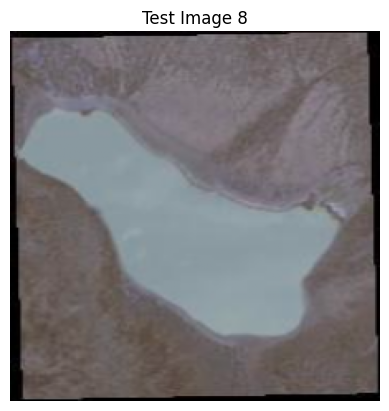

Image 9 - Water Probability: 0.41032955050468445


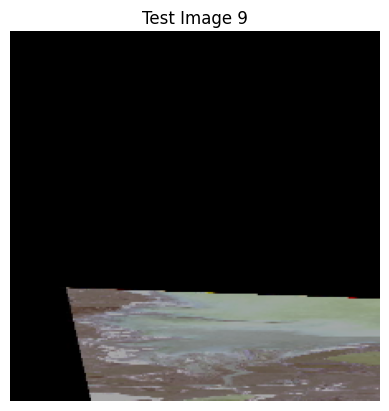

Image 10 - Water Probability: 0.3540816009044647


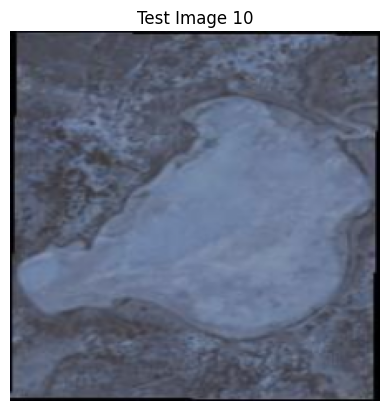

In [ ]:
import matplotlib.pyplot as plt
for i in range(10):
    water_probability = np.mean(predicted_masks[i])
    print(f"Image {i+1} - Water Probability: {water_probability}")

    # Display the image
    plt.imshow(test_images[i])
    plt.title(f"Test Image {i+1}")
    plt.axis("off")
    plt.show()